In [2]:
import matplotlib
%matplotlib inline

import PreFRBLE
from PreFRBLE.convenience import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *


# Basic Usage

Here we explain the basic usage of PrEFRBLE:
1. How to read likelihoods of individual models and realistic LoS scenarios
2. How to add likelihoods of new models
3. How to compute the likelihood of measurements in a scenario as well as the Bayes Factor

## Read Likelihood

We start with reading and plotting the likelihood $L = (P,x)$ of an individual model.
$P$ (100-array) is the probability density of given measure.
$x$ (101-array) is the range of bins in measure corresponding to the values of $P$, which is normalized such that $1 = \sum P \cdot \text{d}x$.
However, PlotLikelihood by default plots $P\cdot x$, thus the shape is identical to the probability of measures, while the displayed values are physical and do not depend on the binning.
So far, all likelihood are written with logarithmic bin ranges.

normalization 1.0000000000000004
list of available measures ['DM', 'RM', 'SM', 'tau']


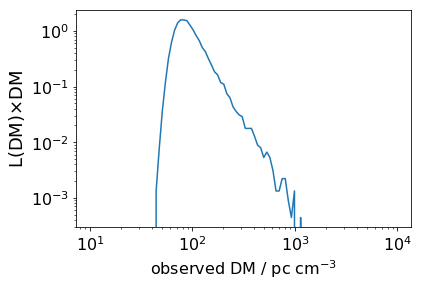

In [9]:

measure = 'DM'
model = 'primordial'
redshift = 0.1


P, x = GetLikelihood_IGM( measure=measure, model=model, redshift=redshift )


PlotLikelihood( P=P, x=x, measure=measure )

print( 'normalization', LikelihoodNorm( P=P, x=x) ) ## same as np.sum( P*np.diff(x) )
print( "list of available measures", measures)

Similar functions exist for the other regions: Host, Inter, Local and MilkyWay. 
Another more general way to read the same Likelihood is the following, which also allows to read out the deviation according to shot noise of the Monte-Carlo simulation

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


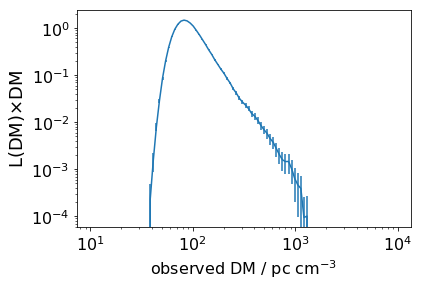

In [5]:

L = GetLikelihood( measure=measure, redshift=redshift, region='IGM', model=model, dev=True )

PlotLikelihood( *L, measure=measure )


In order to investigate realistic scenarios for full LoS, we convolve the likelihoods of measure in the different regions, e. g. 
$$ L = L_1 \ast L_2 = \int P_1(y) P_2(x-y) \text{d}y . $$
To read the resulting likelihood, we first need to define a scenario

In [7]:
scenario = {  ## this is our benchmark scenario, fed to procedures as kwargs-dict of models considered for the different regions are provided as lists (to allow to consider multiple models in the same scenario, e. g. several types of progenitors. Use mixed models only if you know what you are doing)
    'IGM' : ['primordial_C900'],  ## constrained numerical simulatoin of the IGM, considering baryon content f_IGM=0.9 (more info in Hackstein et al. 2018, 2019 & 2020 )
    'Host' : ['Rodrigues18'],     ## ensemble of host galaxies according to Rodrigues et al . 2018
    'Inter' : ['Rodrigues18'],    ## same ensemble for intervening galaxies
    'Local' : ['Piro18/wind'],    ## local environment of magnetar according to Piro & Gaensler 2018
    'N_inter' : True  ## if N_Inter = True, then intervening galaxies are considered realistically, i. e. according to the expecte number of intervened LoS N_inter
}

scenario_local = {  ## certainly, it is possible to choose an single model in order to investigate that more closely
    'Local' : ['Piro18/wind'],
}



With this, we can read out the full likelihood using the following (can take a little while if it hasn't been computed yet, especially for non-absolute measures like RM.)

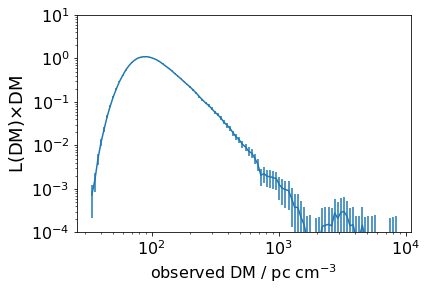

In [7]:

## read likelihood from file or, if cannot be found, compute and write to file. new computation can be forced with force=True
L = GetLikelihood_Full( measure=measure, redshift=redshift, dev=True, **scenario )

PlotLikelihood( *L, measure=measure )


plt.ylim(1e-4,10)
plt.show()


In order to compare these predictions to observations made by telescopes, we have to consider the selection effects of the instrument and assume an intrinsic redshift distribution of FRBs. 
The marginal likelihood of a measure is obtained by integrating results of all redshifts, weighted by the expected amount of FRBs from that redshift $\pi(z)$, e. g.
$$
P(DM) = \int P(DM|z) \pi(z) \text{d}z .
$$ 
We obtain $\pi(z)$ using [FRBpoppy](https://github.com/davidgardenier/frbpoppy/tree/master/frbpoppy), see _notebooks/model/Gardenier20.ipynb_ for details. 
The result can be read out using

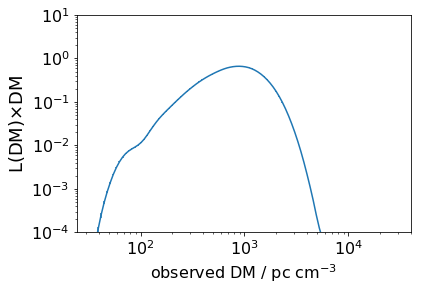

list of available telescopes ['ASKAP_incoh', 'CHIME', 'Parkes']
list of available populations ['SFR', 'coV', 'SMD']


In [8]:

telescope = 'CHIME'
population = 'SMD' ## for redshift distribution to follow Stellar Mass Density

L = GetLikelihood_Telescope( measure=measure, telescope=telescope, population=population, dev=True, **scenario )

PlotLikelihood( *L, measure=measure )

plt.ylim(1e-4,10)
plt.show()

print( "list of available telescopes", telescopes)
print( "list of available populations", populations)


This plot can be compared directly to the distribution of observed measures.

More convenient procedures concerning likelihoods can be found in the _Likelihood.ipynb_ notebook

In [ ]:
### list of all GetLikelihood function
GetLikelihood_Full ## full likelihood of measure for FRBs hosted at given redshift   P(DM|z)
GetLikelihood_Redshift  ## likleihood of host redshift   pi(z)
GetLikelihood_Telescope ## marginal likelihood of measure to be observed by given telescope   P(DM)
GetLikelihood  ## model likelihood, convenient wrapper for the individual regions, set 'region' keyword to extension of function name
GetLikelihood_IGM ## intergalactic medium   P(DM_IGM|z)
GetLikelihood_Host ## host galaxy   P(DM_Host|z)
GetLikelihood_Inter ## intervening galaxy at random redshift   P(DM_Inter|z_FRB)
GetLikelihood_inter ## intervening galaxy at particular redshift   P(DM_Inter|z_inter)
GetLikelihood_Local ## local environment of progenitor   P(DM_Local|z)


## Write New Likelihood

We can easily add another model for individual regions, e. g. using 

In [ ]:

## data arrays to be written
# data = [P, x ]

## where to place data in hdf5 file
# keys = [ KeyLocal( model='dummy', measure, axis=axis )  for axis in ['P','x'] ]  ## note that key "P" is used for all likelihoods. Will be more elegant once L is has an own object class


## write to hdf5 file
Write2h5( likelihood_file_local, data, keys )


New likelihoods have to match the form stated above (under Read Likelihood).
These can either be analytical description of $L$ or can be obtained from a model of the region e. g. via Monte-Carlo simulation.
To obtain likelihoods from the resulting sample, simply use

In [22]:

N = 10**4
sample = np.random.rand(N)

P, x = Likelihood( data=sample, bins=100, log=True, density=True )


deviation is determined by the shot noise of the Monte-Carlo sample, obtained via

In [24]:

dev = LikelihoodDeviation(P=P, x=x, N=N) ## !! P should have norm of 1


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


You can find more details on the models derived so far in the _notebooks/model/_ subdirectory.

## Compute Model Likelihood

Say we have a number of observations of unlocalized FRBs and want to see how likely they are produced in a certain scenario.
For this, we have to indicate the observing telescope, assume a redshift distribution and define the scenario in question.
For this, we read the likelihood $L$ expected to be observed and obtain the corresponding values of $L$ for the observed measures

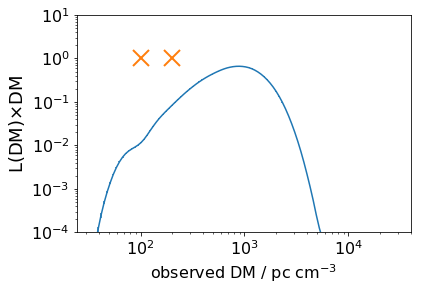

likelihoods [0.00078951 0.00561361]


In [18]:

measure='DM'
measures = [1e2, 2e2]

telescope = 'CHIME'
population = 'SMD' ## for redshift distribution to follow Stellar Mass Density


P0, x0, dev0 = GetLikelihood_Telescope( measure=measure, telescope=telescope, population=population, dev=True, **scenario )

PlotLikelihood( P=P0, x=x0, dev=dev0, measure=measure )

plt.plot( measures, [1]*len(measures), marker='x', markersize=16, markeredgewidth=2, linestyle=' ' )

plt.ylim(1e-4,10)
plt.show()


L0 = Likelihoods( measurements=measures, P=P0, x=x0, dev=dev0 )
print("likelihoods", L0[0])


A single likelihood does not entail any information on its own. 
Instead, the likelihoods for a single measure should be compared for competing scenarios.
This is done by the Bayes factor 
$$
\mathcal{B} = \frac{L_0}{L_1} .
$$
In order to compute $\mathcal{B}$ we repeat the above for a competing scenario and compute the ratio of $L$ (i. e. the probability density function, which has to be used instead of probability, in order to be independent on bin-size).

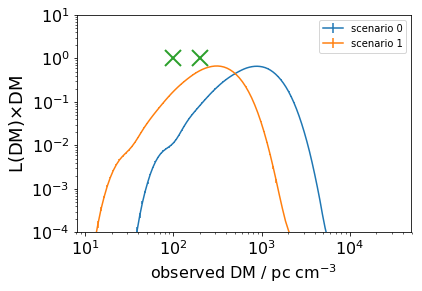

individual Bayes factors: [0.05250517 0.13530673]
Total Bayes = 0.007104, i. e. scenario0 is this much less likely to explain the observed measures


In [21]:

fig, ax = plt.subplots()

PlotLikelihood( P=P0, x=x0, dev=dev0, measure=measure, label='scenario 0', ax=ax )

scenario1 = scenario.copy()
scenario1['IGM'] = ['primordial_C300']  ## choose IGM model with smaller baryon fraction f_IGM = 0.3


P1, x1, dev1 = GetLikelihood_Telescope( measure=measure, telescope=telescope, population=population, dev=True, **scenario1 )

PlotLikelihood( P=P1, x=x1, dev=dev1, measure=measure, label='scenario 1', ax=ax  )

ax.plot( measures, [1]*len(measures), marker='x', markersize=16, markeredgewidth=2, linestyle=' ' )


ax.set_ylim(1e-4,10)
ax.legend()
plt.show()

L1 = Likelihoods( measurements=measures, P=P1, x=x1, dev=dev1 )

print("individual Bayes factors:", L0[0]/L1[0])
print('Total Bayes = %f, i. e. scenario0 is this much less likely to explain the observed measures' % (np.prod( L0[0]/L1[0] )))


Note that according to Bayes theorem, the Bayes factor still has to be multiplied by the ratio of prior for scenario 0 and scenario 1 in order to arrive at the ratio of posterior, which indicates whether scenario 0 can be ruled out in favour of scenario 1.

More applications can be found in the other notebooks

in order to compare to events listed in FRBcat, you can use the following function, which requires you to download the latest version from http://www.frbcat.org/ and place it in the main folder as _frbcat.csv_

In [2]:

GetFRBcat()


array([('FRB191108',  588.1  ,  52.  ,  474. ,       nan,     nan, 'Apertif'),
       ('FRB190907',  310.9  ,  53.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190604',  552.7  ,  32.  ,  -20. ,       nan,     nan, 'CHIME/FRB'),
       ('FRB190523',  760.8  ,  37.  ,    nan, 1.400e+00, 0.66   , 'DSA-10'),
       ('FRB190417', 1378.1  ,  78.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190303',  222.4  ,  29.  , -499.8,       nan,     nan, 'CHIME/FRB'),
       ('FRB190222',  460.6  ,  87.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190212',  651.1  ,  43.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190209',  424.6  ,  46.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190208',  579.9  ,  72.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190117',  393.3  ,  48.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190116',  444.   ,  20.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB181228',  354.2  ,  5